# Olist Customer Segmentation
GitHub location: https://github.com/LarsTinnefeld/olist_ecom_analysis.git

This project is part of a larger Olist ecommerce business analysis and is the capstone project for the Udacity Data Science Nanodegree Program.

![logo](https://i2.wp.com/dataneophyte.com/wp-content/uploads/2019/12/Logo-01.png?resize=513%2C401&ssl=1)

## Questions to answer
1. What are the demographic relationship between customers?
2. How to target specific customer groups successfully?
3. How confident is the classification model?
---
## Table of Contents

I. [Data Import and Wrangling](#data)<br>
II. [Data Preparation](#preparation)<br>
III. [Exploratory Analysis](#eda)<br>
IV. [Customer Segmentation](#segmentation)<br>
V. [TBD](#tbd)<br>
VI. [Evaluation](#evaluation)<br>
VII. [Conclusion](#conclusion)

---
## <a class="anchor" id="data">I. Data Import and Wrangling</a>

### 1. Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 2. Importing data

Data structure:

<img src="https://i.imgur.com/HRhd2Y0.png" width="700" height="450">

**Customer data:**

In [2]:
# Customer lookup table
df_customer = pd.read_csv("../0 - data/olist_customers_dataset.csv")

In [3]:
# Taking a peek
df_customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


This looks like a complete dataset. Doublecheck:

In [5]:
df_customer.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [6]:
# Finding duplicates
df_customer.duplicated().sum()

0

**Order data:**

In [19]:
df_orders = pd.read_csv('../0 - data/df_orders_consolidated.csv')

In [20]:
df_orders.head()

,Unnamed: 0,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_time,...,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_line_cube_in_ltr,price_round
0,0,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-11-09,2016-10-20,21:15:19,...,moveis_decoracao,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0
1,1,35d3a51724a47ef1d0b89911e39cc4ff,27ab53f26192510ff85872aeb3759dcc,delivered,2016-10-04,2016-10-05,2016-10-14,2016-10-26,2016-12-20,14:23:50,...,moveis_decoracao,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0
2,2,c4f710df20f7d1500da1aef81a993f65,4b671f05b6eb9dc1d2c1bae9c8c78536,delivered,2016-10-10,2016-10-10,2016-10-18,2016-10-26,2016-12-14,15:50:01,...,moveis_decoracao,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0
3,3,81e5043198a44ddeb226002ff55d8ad4,ddd15ef77c83eea8c534d2896173a927,delivered,2017-01-09,2017-01-09,2017-01-09,2017-02-24,2017-02-24,00:37:18,...,moveis_decoracao,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,10.752,40.0
4,4,03b218d39c422c250f389120c531b61f,db857a86c685a6a3a02a705961ec1ff1,delivered,2017-01-14,2017-01-14,2017-01-16,2017-01-18,2017-03-01,14:20:01,...,moveis_decoracao,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0


In [21]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102425 entries, 0 to 102424
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     102425 non-null  int64  
 1   order_id                       102425 non-null  object 
 2   customer_id                    102425 non-null  object 
 3   order_status                   102425 non-null  object 
 4   order_purchase_timestamp       102425 non-null  object 
 5   order_approved_at              102425 non-null  object 
 6   order_delivered_carrier_date   102425 non-null  object 
 7   order_delivered_customer_date  102425 non-null  object 
 8   order_estimated_delivery_date  102425 non-null  object 
 9   order_time                     102425 non-null  object 
 10  delivery_time                  102425 non-null  object 
 11  date_ordinal                   102425 non-null  int64  
 12  shipping_time_delta           

This is a cleaned data table from previous analysis. All missing values are added, all duplicated entries are removed and order lines were consolidated. We only need to format the date fields into datetime format.

In [24]:
def convert_to_dt(dat, cols):
    '''Function takes in a dataframe name and date columns for conversion into datetime format'''
    for col in cols:
        dat[col] = pd.to_datetime(dat[col]).dt.date

# converting dates to datetime
convert_to_dt(df_orders, [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
    ])

---
## <a class="anchor" id="eda">II. Exploratory Data Analysis</a>
The focus is on getting an understanding around customers and the demographic relationship between them.

In [26]:
n_customers = df_customer['customer_unique_id'].nunique()
print('Unique customers: {}'.format(n_customers))
n_cities = df_customer['customer_city'].nunique()
print('Unique cities: {}'.format(n_cities))

Unique customers: 96096
Unique cities: 4119


Where are the customers from?

In [27]:
# City disctribution
df_customer['customer_city'].value_counts().sort_values(ascending=False)

sao paulo             15540
rio de janeiro         6882
belo horizonte         2773
brasilia               2131
curitiba               1521
                      ...  
america dourada           1
carnaiba do sertao        1
amargosa                  1
mucurici                  1
cajari                    1
Name: customer_city, Length: 4119, dtype: int64

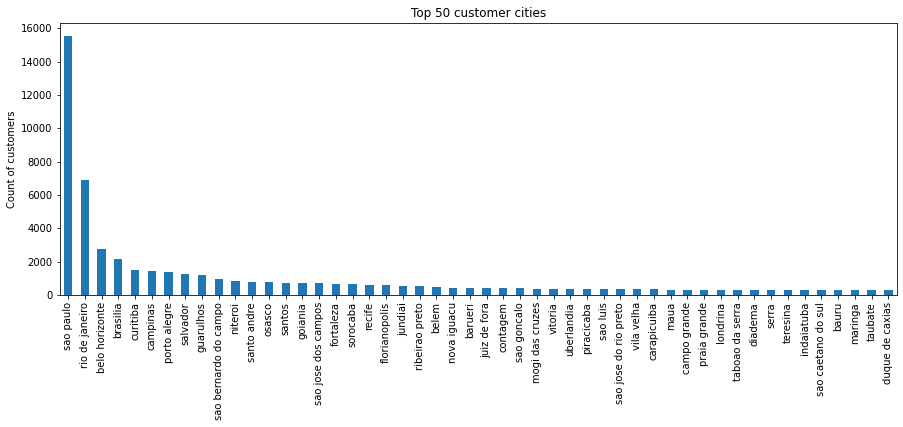

In [28]:
df_customer['customer_city']\
    .value_counts()\
    .sort_values(ascending=False)\
    .head(50)\
    .plot(kind='bar', figsize=(15, 5));

plt.title('Top 50 customer cities');
plt.ylabel('Count of customers');

In [31]:
# How many states are the customers from?
df_customer['customer_state'].nunique()

27

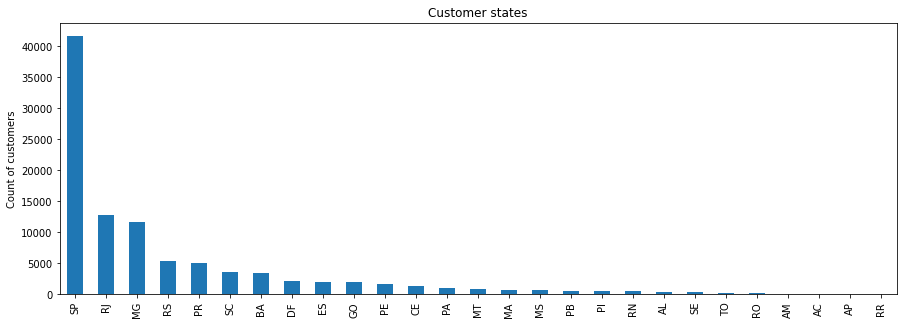

In [29]:
# States disctribution
df_customer['customer_state']\
    .value_counts()\
    .sort_values(ascending=False)\
    .plot(kind='bar', figsize=(15, 5));

plt.title('Customer states');
plt.ylabel('Count of customers');

In [33]:
# How many zip codes?
df_customer['customer_zip_code_prefix'].nunique()

14994

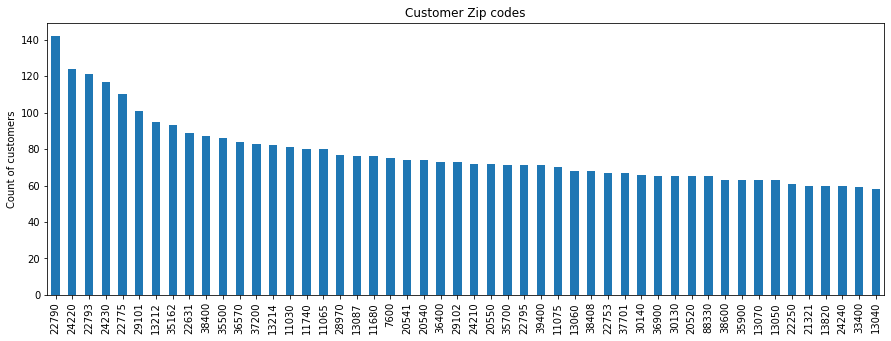

In [34]:
# Top 50 zip codes
df_customer['customer_zip_code_prefix']\
    .value_counts()\
    .sort_values(ascending=False)\
    .head(50)\
    .plot(kind='bar', figsize=(15, 5));

plt.title('Customer Zip codes');
plt.ylabel('Count of customers');